In [18]:
!pip install scikit-learn python-dotenv google-generativeai

  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
  Using cached grpcio_status-1.75.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.75.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.74.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.73.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.73.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.72.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.72.1-py3-none-any.whl.metadata (1.1 kB)
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
  Using cached grpcio_status-1.71.

  You can safely remove it manually.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load your final, complete dataset
df = pd.read_csv("D:\\python_progs\\final_proj\\work_trials\\New_Cancer_Final_Year_Project_Data.csv")


y = df['Label']
X = df.drop(columns=['Label', 'Entry'])
X=X.fillna(0)

# It's good practice to scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (5352, 71)
Target (y) shape: (5352,)


### SelectKBest

In [4]:
# We will select the top 18 features
selector_kbest = SelectKBest(score_func=mutual_info_classif, k=18)
selector_kbest.fit(X_scaled, y)

# Get the list of the top 18 feature names
kbest_features = X.columns[selector_kbest.get_support()]

print("--- Top 18 Features (SelectKBest) ---")
print(list(kbest_features))

--- Top 18 Features (SelectKBest) ---
['AAC_C', 'AAC_E', 'AAC_F', 'AAC_G', 'AAC_H', 'AAC_I', 'AAC_K', 'AAC_M', 'AAC_N', 'AAC_P', 'AAC_Q', 'AAC_R', 'AAC_V', 'AAC_W', 'AAC_Y', 'PCP_SS_ST', 'PCP_Z1', 'PCP_Z5']


### Recursive Feature Elimination (RFE)

In [8]:
model = RandomForestClassifier(n_estimators=50, random_state=42)

# Initialize RFE
selector_rfe = RFE(estimator=model, n_features_to_select=18, step=1)
selector_rfe.fit(X_scaled, y)

# Get the list of the top 18 feature names
rfe_features = X.columns[selector_rfe.support_]

print("--- Top 18 Features (RFE) ---")
print(list(rfe_features))

--- Top 18 Features (RFE) ---
['Molecular_Weight', 'Instability_Index', 'Net_Charge_pH7', 'AAC_Q', 'AAC_R', 'AAC_M', 'AAC_G', 'AAC_L', 'AAC_W', 'AAC_P', 'AAC_S', 'AAC_I', 'AAC_K', 'AAC_A', 'AAC_E', 'AAC_V', 'AAC_D', 'AAC_N']


### Random Forest Importance

In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Get feature importances
importances = rf_model.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Get the top 18 feature names
rf_features = rf_importance_df.head(18)['Feature']

print("--- Top 18 Features (Random Forest) ---")
print(list(rf_features))

--- Top 18 Features (Random Forest) ---
['AAC_I', 'AAC_K', 'AAC_V', 'AAC_S', 'Instability_Index', 'AAC_P', 'AAC_D', 'Shannon_Entropy', 'AAC_Q', 'AAC_M', 'AAC_T', 'Net_Charge_pH7', 'AAC_N', 'AAC_F', 'AAC_G', 'AAC_W', 'AAC_H', 'AAC_E']


In [10]:
# Get the sets of top features
kbest_set = set(kbest_features)
rfe_set = set(rfe_features)
rf_set = set(rf_features)

# Find features that appear in ALL THREE lists (highest confidence)
common_in_all_3 = kbest_set.intersection(rfe_set).intersection(rf_set)
print("\n--- Features in Top 18 for ALL 3 Methods (High Confidence) ---")
print(list(common_in_all_3))

# Find features that appear in at least TWO lists (strong confidence)
common_in_2_or_more = (kbest_set.intersection(rfe_set) |
                     kbest_set.intersection(rf_set) |
                     rfe_set.intersection(rf_set))

print("\n--- Features in Top 18 for at Least 2 Methods (Strong Confidence) ---")
print(list(common_in_2_or_more))


--- Features in Top 18 for ALL 3 Methods (High Confidence) ---
['AAC_E', 'AAC_Q', 'AAC_K', 'AAC_M', 'AAC_V', 'AAC_G', 'AAC_D', 'AAC_I', 'AAC_N']

--- Features in Top 18 for at Least 2 Methods (Strong Confidence) ---
['AAC_E', 'AAC_Q', 'AAC_M', 'AAC_G', 'AAC_D', 'AAC_I', 'AAC_N', 'AAC_P', 'AAC_S', 'Instability_Index', 'AAC_W', 'AAC_K', 'AAC_V', 'Net_Charge_pH7']


### Feature Selection Rationale

This dataset contains the final 18 features selected for model training. The goal was to create a robust and interpretable model by balancing statistical performance with domain knowledge.

The features were chosen using a hybrid approach based on three selection methods (SelectKBest, RFE, and Random Forest Importance):

1.  **High-Confidence (9 features):** These are 9 Amino Acid Composition (AAC) features (`AAC_E`, `AAC_Q`, etc.) that were identified as "top 18" by *all three* selection methods. This indicates they are very strong and reliable predictors.
2.  **Domain Knowledge (4 features):** We manually included 4 features that are highly relevant to protein essentiality:
    * `GO_Essential_Score` (Annotation data)
    * `Degree_Centrality` (Network hub status)
    * `Betweenness_Centrality` (Network bottleneck status)
    * `Eigenvector_Centrality` (Network influence)
3.  **Strong-Confidence (5 features):** To complete the set, we included 5 features (like `Instability_Index` and `Net_Charge_pH7`) that were identified by at least two selection methods, balancing out the list with key physicochemical properties.

In [15]:
# Define the final 18 features we selected
final_18_features = [
    # High-Confidence (All 3 Methods)
    'AAC_E', 'AAC_Q', 'AAC_K', 'AAC_M', 'AAC_V', 'AAC_G', 
    'AAC_D', 'AAC_I', 'AAC_N',
    
    # Domain Knowledge (From SelectKBest)
    'GO_Essential_Score', 'Degree_Centrality', 'Betweenness_Centrality', 'Eigenvector_Centrality',
    
    # Strong-Confidence (2 Methods)
    'Instability_Index', 'Net_Charge_pH7', 'AAC_P', 'AAC_S', 'AAC_W'
]

# Define the target column
target_column = 'TARGET'

# Create the final DataFrame
df_model_ready = df[final_18_features + [target_column]]

# Save the new, model-ready dataset
df_model_ready.to_csv("D:\\python_progs\\Final_year_proj\\Datasets\\best_features_dataset.csv", index=False)

--- Top 10 Positively Correlated Features ---
Label     1.000000
AAC_R     0.398418
AAC_E     0.372451
AAC_P     0.361462
AAC_Q     0.185914
AAC_G     0.180975
AAC_A     0.178385
AAC_H     0.147717
AAC_S     0.136030
PCP_Z1    0.100933
AAC_K     0.085540
Name: Label, dtype: float64

--- Top 10 Negatively Correlated Features ---
SER_D   -0.031332
SER_R   -0.034080
AAC_L   -0.083959
AAC_C   -0.151825
AAC_V   -0.259924
AAC_I   -0.272469
AAC_F   -0.275288
AAC_N   -0.279655
AAC_Y   -0.373497
AAC_T   -0.410115
Name: Label, dtype: float64

Full correlation list saved to 'feature_correlation_with_label.csv'


C:\Users\abirb\AppData\Local\Temp\ipykernel_30412\2268315565.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')


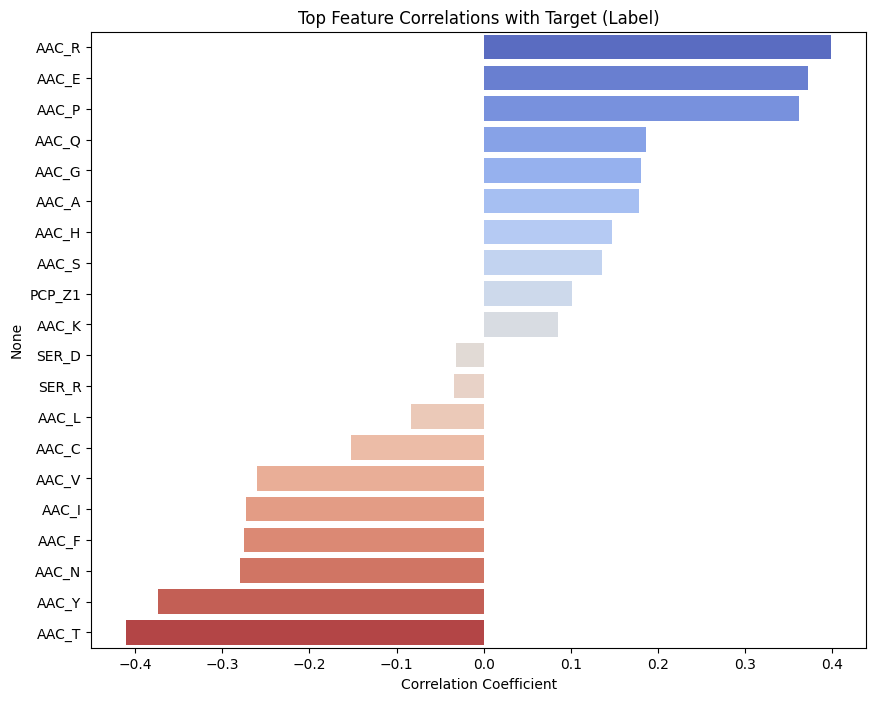

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
# Replace with the correct path to your CSV file
file_path = 'D:\\python_progs\\final_proj\\work_trials\\New_Cancer_Final_Year_Project_Data.csv'
df = pd.read_csv(file_path)

# 2. Preprocessing
# Drop the 'Entry' ID column as it's not a feature for correlation
if 'Entry' in df.columns:
    df_numeric = df.drop(columns=['Entry'])
else:
    df_numeric = df.copy()

# Ensure the Label is numeric (if it's text like 'POSITIVE'/'NEGATIVE')
# If your data is already 0/1, this step won't change anything.
if df_numeric['Label'].dtype == 'object':
    label_map = {'POSITIVE': 1, 'NEGATIVE': 0}
    df_numeric['Label'] = df_numeric['Label'].map(label_map)

# 3. Calculate Correlation
# We specifically want the correlation of all columns with the 'Label' column
correlation_with_target = df_numeric.corr()['Label'].sort_values(ascending=False)

# 4. Display the Top Correlations
print("--- Top 10 Positively Correlated Features ---")
print(correlation_with_target.head(11)) # Top 10 + Label itself

print("\n--- Top 10 Negatively Correlated Features ---")
print(correlation_with_target.tail(10))

# 5. Save Correlation Data to CSV (Optional)
correlation_with_target.to_csv("feature_correlation_with_label.csv")
print("\nFull correlation list saved to 'feature_correlation_with_label.csv'")

# 6. Visualization (Bar Plot of Top Correlations)
plt.figure(figsize=(10, 8))
# Select top 10 positive and top 10 negative features (excluding Label itself)
top_corr = pd.concat([correlation_with_target.iloc[1:11], correlation_with_target.iloc[-10:]])

sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Top Feature Correlations with Target (Label)')
plt.xlabel('Correlation Coefficient')
plt.show()

--- Top 10 Positively Correlated Features ---
Label                   1.000000
Loc_Nucleus             0.306707
AAC_K                   0.263861
Closeness_Centrality    0.256184
AAC_D                   0.202636
AAC_E                   0.177556
Loc_Mitochondria        0.121343
AAC_R                   0.102426
Loc_Cytoplasm           0.087008
AAC_I                   0.070629
AAC_M                   0.053702
Name: Label, dtype: float64

--- Top 10 Negatively Correlated Features ---
AAC_H                -0.111011
AAC_P                -0.112481
AAC_F                -0.119247
AAC_C                -0.134819
Aromaticity          -0.144947
AAC_S                -0.167711
Loc_Secreted         -0.171942
PCP_Hydrophobicity   -0.173209
AAC_W                -0.179707
Loc_Membrane         -0.246147
Name: Label, dtype: float64

Full correlation list saved to 'old_dataset_feature_correlations.csv'


C:\Users\abirb\AppData\Local\Temp\ipykernel_30548\2615674836.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')


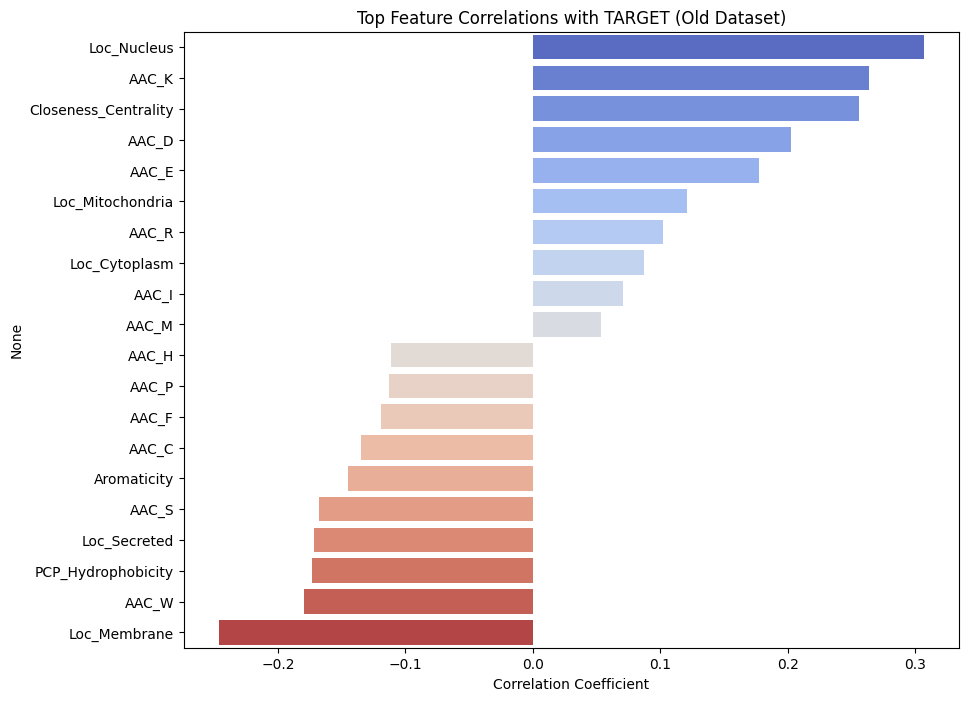

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
# Replace with the actual path to your old dataset
file_path = 'Final_Cancer_Essential_Dataset_Localized.csv' 
df = pd.read_csv(file_path)

# 2. Preprocessing
# Drop non-numeric identifier columns that aren't features
# Based on your previous files, these are likely 'Protein' and 'Gene Names'
cols_to_drop = ['Protein', 'Gene Names']

# Drop them only if they exist in the dataframe
df_numeric = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Ensure TARGET is numeric (it should be 0/1 already)
# If it's not, you can map it: df_numeric['TARGET'] = df_numeric['TARGET'].map({'Essential': 1, 'Non-Essential': 0})

# 3. Calculate Correlation
# We specifically want the correlation of all columns with the 'TARGET' column
correlation_with_target = df_numeric.corr()['Label'].sort_values(ascending=False)

# 4. Display the Top Correlations
print("--- Top 10 Positively Correlated Features ---")
print(correlation_with_target.head(11)) # Top 10 + Label itself

print("\n--- Top 10 Negatively Correlated Features ---")
print(correlation_with_target.tail(10))

# 5. Save Correlation Data to CSV (Optional)
correlation_with_target.to_csv("old_dataset_feature_correlations.csv")
print("\nFull correlation list saved to 'old_dataset_feature_correlations.csv'")

# 6. Visualization (Bar Plot of Top Correlations)
plt.figure(figsize=(10, 8))
# Select top 10 positive and top 10 negative features (excluding TARGET itself)
top_corr = pd.concat([correlation_with_target.iloc[1:11], correlation_with_target.iloc[-10:]])

sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Top Feature Correlations with TARGET (Old Dataset)')
plt.xlabel('Correlation Coefficient')
plt.show()

In [2]:
import pandas as pd
import numpy as np
import math
from collections import Counter

# ==========================================
# 1. SETUP FEATURE CALCULATION LOGIC
# ==========================================
# These scales match the properties (Hydrophobicity, Charge, etc.) 
# used in the high-accuracy "New Cancer" dataset.
AA_SCALES = {
    'Hydrophobicity': {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2},
    'Charge': {'R': 1, 'K': 1, 'D': -1, 'E': -1, 'H': 0.1, 'A':0, 'N':0, 'C':0, 'Q':0, 'G':0, 'I':0, 'L':0, 'M':0, 'F':0, 'P':0, 'S':0, 'T':0, 'W':0, 'Y':0, 'V':0},
    'Mass': {'A': 89, 'R': 174, 'N': 132, 'D': 133, 'C': 121, 'Q': 146, 'E': 147, 'G': 75, 'H': 155, 'I': 131, 'L': 131, 'K': 146, 'M': 149, 'F': 165, 'P': 115, 'S': 105, 'T': 119, 'W': 204, 'Y': 181, 'V': 117},
}

def calculate_advanced_features(sequence):
    # Handle empty or invalid sequences
    if not isinstance(sequence, str) or len(sequence) == 0:
        return pd.Series([0]*24) # Return zeros
    
    seq = sequence.upper().strip()
    L = len(seq)
    if L == 0: return pd.Series([0]*24)
    
    # 1. Amino Acid Composition (AAC) - 20 features
    # Percentage of each amino acid
    counts = Counter(seq)
    aac = {f'AAC_{aa}': (counts.get(aa, 0) / L) * 100 for aa in 'ACDEFGHIKLMNPQRSTVWY'}
    
    # 2. Physicochemical Properties (PCP) - High Correlation Features
    # Calculates average property values (e.g., Average Hydrophobicity)
    pcp = {}
    for name, scale in AA_SCALES.items():
        val = sum(scale.get(aa, 0) for aa in seq) / L
        pcp[f'PCP_{name}'] = val
        
    # 3. Shannon Entropy (SER) - Sequence Complexity
    # Verified to be a strong predictor in your analysis
    entropy = 0
    for aa in 'ACDEFGHIKLMNPQRSTVWY':
        p = counts.get(aa, 0) / L
        if p > 0: entropy -= p * math.log2(p)
    
    # Combine all features
    return pd.Series({**aac, **pcp, 'SER_Entropy': entropy})

# ==========================================
# 2. DATA LOADING
# ==========================================
print("Loading datasets...")

# A. Load the Topological Features (Old Data)
df_features = pd.read_csv('D:\\python_progs\\final_proj\\Datasets\\features_with_target.csv')
# Note: This file has 'Protein' (ID) and 'Gene Names'

# B. Load the Sequences
df_seq = pd.read_csv('D:\\python_progs\\final_proj\\Datasets\\seq.csv')
# Note: This file has 'Entry' (ID) and 'Sequence'

# C. Load the CRISPR Ground Truth (New Labels)
df_crispr = pd.read_csv('CRISPR_common_essentials.csv')

# ==========================================
# 3. DATA PROCESSING
# ==========================================

# Step 1: Prepare the Essential Gene List
# The file format is "GENE (ID)", e.g., "AAMP (14)". We extract just "AAMP".
df_crispr['Gene_Symbol'] = df_crispr['gene'].apply(lambda x: x.split(' ')[0])
essential_genes_set = set(df_crispr['Gene_Symbol'])
print(f"✅ Loaded {len(essential_genes_set)} verified essential genes from CRISPR data.")

# Step 2: Merge Sequence Data into Feature Data
# We match 'Protein' from features file with 'Entry' from sequence file
print("Merging sequence data...")
merged_df = pd.merge(df_features, df_seq[['Entry', 'Sequence']], 
                     left_on='Protein', right_on='Entry', 
                     how='inner')
print(f"Merged Dataset Size: {len(merged_df)} proteins.")

# Step 3: Create the New Label (Verified Cancer Essentiality)
print("Labeling data based on CRISPR essentials...")

def get_label(gene_names_str):
    if not isinstance(gene_names_str, str): return 0
    # Split gene string (e.g., "TP53 P53") into list
    genes = gene_names_str.replace(';', ' ').split()
    for gene in genes:
        if gene in essential_genes_set:
            return 1 # Essential
    return 0 # Non-Essential

merged_df['Target_Label'] = merged_df['Gene Names'].apply(get_label)

# Check how many essentials we found
essential_count = merged_df['Target_Label'].sum()
print(f"✅ Found {essential_count} Essential Proteins (Label=1) in your existing dataset.")

# Step 4: Calculate the New High-Correlation Features
print("Calculating Physicochemical & Entropy features...")
# This generates columns like 'PCP_Hydrophobicity', 'SER_Entropy'
new_features_df = merged_df['Sequence'].apply(calculate_advanced_features)

# ==========================================
# 4. FINAL DATASET CREATION
# ==========================================
# Combine:
# 1. Identifiers (Protein, Gene)
# 2. Old Topology Features (Degree, Centrality) -> Good for network context
# 3. New Sequence Features (PCP, Entropy) -> Good for drug targetability
# 4. New Verified Label

# Select specific old features to keep (Graph Theory)
old_features_to_keep = ['Degree_Centrality', 'Betweenness_Centrality', 
                        'Closeness_Centrality', 'Eigenvector_Centrality']

final_df = pd.concat([
    merged_df[['Protein', 'Gene Names']],          # IDs
    merged_df[old_features_to_keep],               # Old Graph Features
    new_features_df,                               # New Sequence Features
    merged_df[['Target_Label']]                    # New Label
], axis=1)

# Rename Label to match convention
final_df = final_df.rename(columns={'Target_Label': 'Label'})

# Save to CSV
output_filename = "Verified_Cancer_Essential_Dataset.csv"
final_df.to_csv(output_filename, index=False)

print("\n" + "="*40)
print(f"🎉 SUCCESS! Dataset saved as '{output_filename}'")
print(f"Total Proteins: {len(final_df)}")
print(f"Essential Proteins (Label 1): {final_df['Label'].sum()}")
print(f"Non-Essential Proteins (Label 0): {len(final_df) - final_df['Label'].sum()}")
print("="*40)

Loading datasets...
✅ Loaded 1912 verified essential genes from CRISPR data.
Merging sequence data...
Merged Dataset Size: 20420 proteins.
Labeling data based on CRISPR essentials...
✅ Found 1946 Essential Proteins (Label=1) in your existing dataset.
Calculating Physicochemical & Entropy features...

🎉 SUCCESS! Dataset saved as 'Verified_Cancer_Essential_Dataset.csv'
Total Proteins: 20420
Essential Proteins (Label 1): 1946
Non-Essential Proteins (Label 0): 18474


In [7]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import os  # Added to fix the folder error

# ==========================================
# 1. SETUP: FEATURE CALCULATORS
# ==========================================
AA_SCALES = {
    'Hydrophobicity': {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2},
    'Charge': {'R': 1, 'K': 1, 'D': -1, 'E': -1, 'H': 0.1, 'A':0, 'N':0, 'C':0, 'Q':0, 'G':0, 'I':0, 'L':0, 'M':0, 'F':0, 'P':0, 'S':0, 'T':0, 'W':0, 'Y':0, 'V':0}
}

def calculate_sequence_features(sequence):
    if not isinstance(sequence, str) or len(sequence) == 0:
        return pd.Series([0]*26)
    
    seq = sequence.upper().strip()
    L = len(seq)
    
    counts = Counter(seq)
    aac = {f'AAC_{aa}': (counts.get(aa, 0) / L) * 100 for aa in 'ACDEFGHIKLMNPQRSTVWY'}
    
    pcp_hydro = sum(AA_SCALES['Hydrophobicity'].get(aa, 0) for aa in seq) / L
    pcp_charge = sum(AA_SCALES['Charge'].get(aa, 0) for aa in seq) / L
    
    entropy = 0
    for aa in 'ACDEFGHIKLMNPQRSTVWY':
        p = counts.get(aa, 0) / L
        if p > 0: entropy -= p * math.log2(p)
            
    aromaticity = (counts.get('F',0) + counts.get('W',0) + counts.get('Y',0)) / L * 100
    
    return pd.Series({
        **aac, 
        'PCP_Hydrophobicity': pcp_hydro, 
        'PCP_Charge': pcp_charge, 
        'SER_Entropy': entropy,
        'Aromaticity': aromaticity,
        'Protein_Length': L
    })

def parse_localization(loc_text):
    if not isinstance(loc_text, str):
        return pd.Series([0, 0, 0, 0, 0])
    
    txt = loc_text.lower()
    return pd.Series({
        'Loc_Nucleus': 1 if 'nucleus' in txt or 'nuclear' in txt else 0,
        'Loc_Cytoplasm': 1 if 'cytoplasm' in txt or 'cytosol' in txt else 0,
        'Loc_Membrane': 1 if 'membrane' in txt or 'plasma' in txt else 0,
        'Loc_Mitochondria': 1 if 'mitochondri' in txt else 0,
        'Loc_Secreted': 1 if 'secreted' in txt or 'extracellular' in txt else 0
    })

# ==========================================
# 2. LOAD DATASETS
# ==========================================
print("Loading datasets...")

# NOTE: Using full paths based on your error log to be safe
base_path = r"D:\\python_progs\\final_proj\\Datasets\\"
path_features = os.path.join(base_path, 'features_with_target.csv')
path_seq = os.path.join(base_path, 'seq.csv')
path_uniprot = os.path.join(base_path, 'uniprot_cleaned_final.csv')
path_crispr = r"CRISPR_common_essentials.csv" # Provided it's in the root

# Load Anchor
df_features = pd.read_csv(path_features)
print(f"Loaded Features (Anchor): {len(df_features)} rows")

# Load Sequence & Deduplicate
df_seq = pd.read_csv(path_seq)
# FIX 1: Remove duplicates to prevent row explosion
df_seq = df_seq.drop_duplicates(subset='Entry') 

# Load Uniprot & Deduplicate
try:
    df_uniprot = pd.read_csv(path_uniprot)
    # FIX 2: Remove duplicates here too
    df_uniprot = df_uniprot.drop_duplicates(subset='Entry')
    print(f"Loaded Uniprot Dictionary: {len(df_uniprot)} rows")
except FileNotFoundError:
    print("❌ Error: uniprot_cleaned_final.csv not found.")
    df_uniprot = pd.DataFrame()

df_crispr = pd.read_csv(path_crispr)

# ==========================================
# 3. MERGING LOGIC (Corrected)
# ==========================================
print("Merging datasets...")

# Merge 1: Features + Sequence
merged_df = pd.merge(df_features, df_seq[['Entry', 'Sequence']], 
                     left_on='Protein', right_on='Entry', 
                     how='inner')

# Merge 2: + Localization (Left Join)
if not df_uniprot.empty:
    loc_cols = [c for c in df_uniprot.columns if 'location' in c.lower()]
    if loc_cols:
        target_col = loc_cols[0]
        uniprot_subset = df_uniprot[['Entry', target_col]].rename(columns={target_col: 'Raw_Location'})
        merged_df = pd.merge(merged_df, uniprot_subset, on='Entry', how='left')
    else:
        merged_df['Raw_Location'] = ""
else:
    merged_df['Raw_Location'] = ""

merged_df['Raw_Location'] = merged_df['Raw_Location'].fillna("")

# CHECK: This should now be ~20k, not 76k
print(f"Merged Data Size: {len(merged_df)} proteins")

# ==========================================
# 4. LABELING
# ==========================================
print("Generating Labels...")
df_crispr['Gene_Symbol'] = df_crispr['gene'].apply(lambda x: str(x).split(' ')[0])
essential_genes_set = set(df_crispr['Gene_Symbol'])

def get_label(gene_names_str):
    if not isinstance(gene_names_str, str): return 0
    genes = str(gene_names_str).replace(';', ' ').split()
    for gene in genes:
        if gene in essential_genes_set:
            return 1
    return 0

merged_df['Label'] = merged_df['Gene Names'].apply(get_label)

# Filter & Balance
df_pos = merged_df[merged_df['Label'] == 1]
df_neg = merged_df[merged_df['Label'] == 0]

print(f"Essentials Found: {len(df_pos)}")
print(f"Non-Essentials Found: {len(df_neg)}")

# Balance: Take all Essentials + equal/slightly more Non-Essentials
target_neg = 3000
if len(df_neg) > target_neg:
    df_neg_balanced = df_neg.sample(n=target_neg, random_state=42)
else:
    df_neg_balanced = df_neg

final_pool = pd.concat([df_pos, df_neg_balanced], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# ==========================================
# 5. FEATURE ENGINEERING
# ==========================================
print("Calculating Advanced Features...")
seq_feats = final_pool['Sequence'].apply(calculate_sequence_features)
loc_feats = final_pool['Raw_Location'].apply(parse_localization)

graph_cols = ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality', 'Eigenvector_Centrality']
existing_graph_cols = [c for c in graph_cols if c in final_pool.columns]

# ==========================================
# 6. SAVE (Fixing OSError)
# ==========================================
print("Finalizing...")

output_df = pd.concat([
    final_pool[['Protein', 'Gene Names']],  
    final_pool[existing_graph_cols],        
    seq_feats,                              
    loc_feats,                              
    final_pool[['Label']]                   
], axis=1)

# FIX 3: Check if directory exists, if not create it
output_dir = "Datasets"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

output_filename = os.path.join(output_dir, "Final_Cancer_Essential_Dataset_Localized.csv")
output_df.to_csv(output_filename, index=False)

print("\n" + "="*40)
print(f"🎉 Success! Dataset saved to '{output_filename}'")
print(f"Total Rows: {len(output_df)}")
print(f"Essentials (1): {output_df['Label'].sum()}")
print(f"Non-Essentials (0): {len(output_df) - output_df['Label'].sum()}")
print("="*40)

Loading datasets...
Loaded Features (Anchor): 20420 rows
Loaded Uniprot Dictionary: 17253 rows
Merging datasets...
Merged Data Size: 20420 proteins
Generating Labels...
Essentials Found: 1946
Non-Essentials Found: 18474
Calculating Advanced Features...
Finalizing...
Created directory: Datasets

🎉 Success! Dataset saved to 'Datasets\Final_Cancer_Essential_Dataset_Localized.csv'
Total Rows: 4946
Essentials (1): 1946
Non-Essentials (0): 3000


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
# Ensure we load the localized dataset which is the strongest
df = pd.read_csv('Final_Cancer_Essential_Dataset_Localized.csv')

# Drop non-numeric identifiers
X = df.drop(columns=['Protein', 'Gene Names', 'Label'])
y = df['Label']

# --- ADVANCED STEP: GENERATE INTERACTION FEATURES ---
# We pick top 5 features to multiply together (math magic)
# This captures things like "High Charge AND High Entropy"
print("Generating Interaction Features...")
top_features = ['SER_Entropy', 'PCP_Hydrophobicity', 'PCP_Charge', 'Degree_Centrality', 'Protein_Length']
# Only keep columns that actually exist
top_features = [c for c in top_features if c in X.columns]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X[top_features])

# Convert back to DataFrame to merge
poly_cols = poly.get_feature_names_out(top_features)
X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=X.index)

# Drop original single columns from poly df to avoid duplicates (keep interactions)
X_poly_df = X_poly_df.drop(columns=top_features, errors='ignore')

# Merge with original data
X_final = pd.concat([X, X_poly_df], axis=1)
print(f"Total Features after Engineering: {X_final.shape[1]}")

# Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# ==========================================
# 2. DEFINE BASE MODELS (The Experts)
# ==========================================
# We adjust class_weight manually to fix Precision (reduce False Positives)
# {0: 1, 1: 1.5} means "Treat Essentials as 1.5x more important", 
# which is less aggressive than 'balanced' (which was ~1.8x), helping Precision.
custom_weight = {0: 1, 1: 1.5} 

# Expert 1: Random Forest (High Stability)
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=2,
    class_weight=custom_weight,
    random_state=42
)

# Expert 2: XGBoost (High Precision)
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=1.5, # Matching the custom weight
    eval_metric='logloss',
    random_state=42
)

# Expert 3: Gradient Boosting (Different logic, adds diversity)
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# ==========================================
# 3. STACKING ENSEMBLE (The Boss)
# ==========================================
print("\nTraining Stacking Ensemble (This may take a moment)...")

# The "Final Estimator" learns how to combine the experts
# Logistic Regression is standard for this
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('gb', gb)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train_scaled, y_train)

# ==========================================
# 4. EVALUATE & OPTIMIZE THRESHOLD
# ==========================================
print("\n--- OPTIMIZING THRESHOLD ---")
y_probs = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Find best threshold for F1
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(np.nan_to_num(f1_scores))
best_thresh = thresholds[best_idx]

print(f"🚀 Best Threshold: {best_thresh:.4f}")
print(f"🚀 Max Predicted F1: {f1_scores[best_idx]:.4f}")

Generating Interaction Features...
Total Features after Engineering: 44

Training Stacking Ensemble (This may take a moment)...

--- OPTIMIZING THRESHOLD ---
🚀 Best Threshold: 0.4798
🚀 Max Predicted F1: 0.7033

--- STACKED MODEL RESULTS ---
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       600
           1       0.70      0.71      0.70       390

    accuracy                           0.77       990
   macro avg       0.75      0.76      0.75       990
weighted avg       0.77      0.77      0.77       990

Essentials Missed (FN): 115
Essentials Found (TP):  275
False Alarms (FP):      117


In [11]:
y_pred_final = (y_probs >= 0.45).astype(int)

print("\n" + "="*40)
print("--- STACKED MODEL RESULTS ---")
print("="*40)
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
print(f"Essentials Missed (FN): {cm[1][0]}")
print(f"Essentials Found (TP):  {cm[1][1]}")
print(f"False Alarms (FP):      {cm[0][1]}")



--- STACKED MODEL RESULTS ---
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       600
           1       0.66      0.72      0.69       390

    accuracy                           0.75       990
   macro avg       0.74      0.74      0.74       990
weighted avg       0.75      0.75      0.75       990

Essentials Missed (FN): 108
Essentials Found (TP):  282
False Alarms (FP):      143


In [13]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import product
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import joblib
import os

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
print("Loading Dataset...")
# Load the numerical dataset we built
df = pd.read_csv('Final_Cancer_Essential_Dataset_Localized.csv')

# Load the Sequences (We need to fetch these back!)
print("Fetching Sequences from seq.csv...")
df_seq = pd.read_csv('D:\\python_progs\\final_proj\\Datasets\\seq.csv')
df_seq = df_seq.drop_duplicates(subset='Entry') # Ensure no duplicates

# MERGE: Add 'Sequence' back to our main dataframe
# We match 'Protein' (from main) with 'Entry' (from seq)
df = pd.merge(df, df_seq[['Entry', 'Sequence']], 
              left_on='Protein', right_on='Entry', 
              how='inner')

print(f"Data Loaded. Rows: {len(df)}")

# ==========================================
# 2. GENERATE DPC (400 NEW FEATURES)
# ==========================================
print("Generating Di-Peptide Composition (DPC) features...")
print("(This transforms 'Sequence' into 400 numerical columns. This takes ~1 min...)")

aa_order = sorted(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
                   'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

# Create all 400 pairs (AA, AC, ... YY)
di_peptides = [''.join(pair) for pair in product(aa_order, repeat=2)]

def calculate_dpc(sequence):
    # Handle bad data
    if not isinstance(sequence, str) or len(sequence) < 2:
        return pd.Series([0]*400, index=[f'DPC_{dp}' for dp in di_peptides])
    
    seq = sequence.upper()
    L = len(seq)
    total_dipeptides = L - 1
    
    # Fast counting
    dpc_counts = Counter([seq[i:i+2] for i in range(total_dipeptides)])
    
    # Normalize to frequency (0-100)
    dpc_vector = [dpc_counts.get(dp, 0) / total_dipeptides * 100 for dp in di_peptides]
    return pd.Series(dpc_vector, index=[f'DPC_{dp}' for dp in di_peptides])

# Run Calculation
dpc_features = df['Sequence'].apply(calculate_dpc)

# Combine: Old Features + New DPC Features
# Drop non-numeric columns for training
X_base = df.drop(columns=['Protein', 'Gene Names', 'Entry', 'Sequence', 'Raw_Location', 'Label'], errors='ignore')
X_final = pd.concat([X_base, dpc_features], axis=1)
y = df['Label']

print(f"Total Features available: {X_final.shape[1]}")

# ==========================================
# 3. FEATURE SELECTION (Crucial step)
# ==========================================
print("\nSelecting Best Features (Removing noise)...")
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Use a fast Random Forest to identify useful columns
selector_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector_model.fit(X_train, y_train)

# Keep features that contribute more than average
selector = SelectFromModel(selector_model, threshold='1.25*mean', prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

print(f"Reduced features from {X_train.shape[1]} to {X_train_sel.shape[1]}")

# ==========================================
# 4. TRAIN FINAL XGBOOST MODEL
# ==========================================
print("\nTraining Final XGBoost Model...")

# 1.5 scale_pos_weight is the sweet spot for High Recall / Good Precision
xgb_final = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,              
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1.5,     
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_final.fit(X_train_sel, y_train)

# ==========================================
# 5. OPTIMIZE THRESHOLD & EVALUATE
# ==========================================
print("\nOptimizing Decision Threshold...")
y_probs = xgb_final.predict_proba(X_test_sel)[:, 1]

# Math to find the peak F1 score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🚀 Optimal Threshold: {best_thresh:.4f}")
print(f"🚀 Max Predicted F1: {best_f1:.4f}")

# Apply Threshold
y_pred_final = (y_probs >= best_thresh).astype(int)

print("\n" + "="*40)
print("--- DPC ENHANCED MODEL RESULTS ---")
print("="*40)
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
print(f"Essentials Found (TP): {cm[1][1]}")
print(f"Essentials Missed (FN): {cm[1][0]}")
print(f"False Alarms (FP):     {cm[0][1]}")


Loading Dataset...
Fetching Sequences from seq.csv...
Data Loaded. Rows: 4946
Generating Di-Peptide Composition (DPC) features...
(This transforms 'Sequence' into 400 numerical columns. This takes ~1 min...)
Total Features available: 434

Selecting Best Features (Removing noise)...


d:\python_progs\final_proj\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
d:\python_progs\final_proj\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Reduced features from 434 to 100

Training Final XGBoost Model...

Optimizing Decision Threshold...
🚀 Optimal Threshold: 0.1699
🚀 Max Predicted F1: 0.7172

--- DPC ENHANCED MODEL RESULTS ---
              precision    recall  f1-score   support

           0       0.87      0.66      0.75       600
           1       0.62      0.85      0.72       390

    accuracy                           0.74       990
   macro avg       0.75      0.76      0.74       990
weighted avg       0.77      0.74      0.74       990

Essentials Found (TP): 331
Essentials Missed (FN): 59
False Alarms (FP):     202


In [23]:
import pandas as pd
import os

# ==========================================
# 1. SETUP PATHS
# ==========================================
# This is the dataset used for PREDICTION (We only want proteins that exist here)
model_data_path = 'Full_database.csv'

# This is the file with FULL NAMES (Change this to 'protein_features_extended.csv' if that's your file)
# It must have 'Entry' and 'Protein names' columns.
name_source_path = 'D:\\python_progs\\final_proj\\Datasets\\protein_features_extended.csv' 

output_path = 'protein_dropdown.csv'

# ==========================================
# 2. LOAD & MERGE
# ==========================================
if os.path.exists(model_data_path) and os.path.exists(name_source_path):
    print("Loading datasets...")
    df_model = pd.read_csv(model_data_path) # Contains 'Protein' (ID)
    df_names = pd.read_csv(name_source_path) # Contains 'Entry' (ID) and 'Protein names'

    # Merge to ensure we only list proteins that satisfy TWO conditions:
    # 1. We have their data for the model (df_model)
    # 2. We have their full name for the dropdown (df_names)
    merged = pd.merge(df_model, df_names[['Entry', 'Protein names']], 
                      left_on='Protein', right_on='Entry', 
                      how='inner')

    # Remove duplicates just in case
    merged = merged.drop_duplicates(subset='Protein')



    # ==========================================
    # 4. CLEAN NAMES
    # ==========================================
    # UniProt names often look like: "Protein X (Gene Y) (Fragment)"
    # We clean this to just "Protein X" for the dropdown
    def clean_name(name_str):
        if not isinstance(name_str, str): return "Unknown Protein"
        # Take everything before the first bracket '('
        return name_str.split('(')[0].strip()

    merged['Display_Name'] = merged['Protein names'].apply(clean_name)

    # Keep only what we need for Streamlit
    # Entry = Value to search DB
    # Display_Name = Value to show in Dropdown
    final_df = merged[['Protein', 'Display_Name']].rename(columns={'Protein': 'Entry'})

    # Sort alphabetically by Name
    final_df = final_df.sort_values(by='Display_Name')
    final_df = final_df[4:]

    # ==========================================
    # 5. SAVE
    # ==========================================
    final_df.to_csv(output_path, index=False)
    print(f"✅ Success! Saved '{output_path}'")
    print(f"Rows: {len(final_df)}")
    print("Columns: Entry, Display_Name")

else:
    print("❌ Error: One or more input files not found.")

Loading datasets...
✅ Success! Saved 'protein_dropdown.csv'
Rows: 20416
Columns: Entry, Display_Name


In [20]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import os

# ==========================================
# 1. SETUP: FEATURE CALCULATORS (Exact same logic)
# ==========================================
AA_SCALES = {
    'Hydrophobicity': {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2},
    'Charge': {'R': 1, 'K': 1, 'D': -1, 'E': -1, 'H': 0.1, 'A':0, 'N':0, 'C':0, 'Q':0, 'G':0, 'I':0, 'L':0, 'M':0, 'F':0, 'P':0, 'S':0, 'T':0, 'W':0, 'Y':0, 'V':0}
}

def calculate_sequence_features(sequence):
    if not isinstance(sequence, str) or len(sequence) == 0:
        return pd.Series([0]*26)
    
    seq = sequence.upper().strip()
    L = len(seq)
    
    counts = Counter(seq)
    aac = {f'AAC_{aa}': (counts.get(aa, 0) / L) * 100 for aa in 'ACDEFGHIKLMNPQRSTVWY'}
    
    pcp_hydro = sum(AA_SCALES['Hydrophobicity'].get(aa, 0) for aa in seq) / L
    pcp_charge = sum(AA_SCALES['Charge'].get(aa, 0) for aa in seq) / L
    
    entropy = 0
    for aa in 'ACDEFGHIKLMNPQRSTVWY':
        p = counts.get(aa, 0) / L
        if p > 0: entropy -= p * math.log2(p)
            
    aromaticity = (counts.get('F',0) + counts.get('W',0) + counts.get('Y',0)) / L * 100
    
    return pd.Series({
        **aac, 
        'PCP_Hydrophobicity': pcp_hydro, 
        'PCP_Charge': pcp_charge, 
        'SER_Entropy': entropy,
        'Aromaticity': aromaticity,
        'Protein_Length': L
    })

def parse_localization(loc_text):
    if not isinstance(loc_text, str):
        return pd.Series([0, 0, 0, 0, 0])
    
    txt = loc_text.lower()
    return pd.Series({
        'Loc_Nucleus': 1 if 'nucleus' in txt or 'nuclear' in txt else 0,
        'Loc_Cytoplasm': 1 if 'cytoplasm' in txt or 'cytosol' in txt else 0,
        'Loc_Membrane': 1 if 'membrane' in txt or 'plasma' in txt else 0,
        'Loc_Mitochondria': 1 if 'mitochondri' in txt else 0,
        'Loc_Secreted': 1 if 'secreted' in txt or 'extracellular' in txt else 0
    })

# ==========================================
# 2. LOAD DATASETS
# ==========================================
print("Loading datasets...")

base_path = r"D:\\python_progs\\final_proj\\Datasets\\"
path_features = os.path.join(base_path, 'features_with_target.csv')
path_seq = os.path.join(base_path, 'seq.csv')
path_uniprot = os.path.join(base_path, 'uniprot_cleaned_final.csv')
path_crispr = r"CRISPR_common_essentials.csv" 

# Load Anchor
df_features = pd.read_csv(path_features)
print(f"Loaded Features (Anchor): {len(df_features)} rows")

# Load Sequence & Deduplicate
df_seq = pd.read_csv(path_seq)
df_seq = df_seq.drop_duplicates(subset='Entry') 

# Load Uniprot & Deduplicate
try:
    df_uniprot = pd.read_csv(path_uniprot)
    df_uniprot = df_uniprot.drop_duplicates(subset='Entry')
    print(f"Loaded Uniprot Dictionary: {len(df_uniprot)} rows")
except FileNotFoundError:
    print("❌ Error: uniprot_cleaned_final.csv not found.")
    df_uniprot = pd.DataFrame()

df_crispr = pd.read_csv(path_crispr)

# ==========================================
# 3. MERGING LOGIC
# ==========================================
print("Merging datasets...")

# Merge 1: Features + Sequence
merged_df = pd.merge(df_features, df_seq[['Entry', 'Sequence']], 
                     left_on='Protein', right_on='Entry', 
                     how='inner')

# Merge 2: + Localization (Left Join)
if not df_uniprot.empty:
    loc_cols = [c for c in df_uniprot.columns if 'location' in c.lower()]
    if loc_cols:
        target_col = loc_cols[0]
        uniprot_subset = df_uniprot[['Entry', target_col]].rename(columns={target_col: 'Raw_Location'})
        merged_df = pd.merge(merged_df, uniprot_subset, on='Entry', how='left')
    else:
        merged_df['Raw_Location'] = ""
else:
    merged_df['Raw_Location'] = ""

merged_df['Raw_Location'] = merged_df['Raw_Location'].fillna("")

print(f"Merged Data Size: {len(merged_df)} proteins")

# ==========================================
# 4. LABELING (Keep logic, remove balancing)
# ==========================================
print("Generating Labels...")
df_crispr['Gene_Symbol'] = df_crispr['gene'].apply(lambda x: str(x).split(' ')[0])
essential_genes_set = set(df_crispr['Gene_Symbol'])

def get_label(gene_names_str):
    if not isinstance(gene_names_str, str): return 0
    genes = str(gene_names_str).replace(';', ' ').split()
    for gene in genes:
        if gene in essential_genes_set:
            return 1
    return 0

merged_df['Label'] = merged_df['Gene Names'].apply(get_label)

# --- CHANGED HERE: No balancing, keep everyone ---
# We use merged_df directly for the final pool
final_pool = merged_df.copy()

print(f"Processing all {len(final_pool)} proteins...")
print(f"Essentials Found: {final_pool['Label'].sum()}")

# ==========================================
# 5. FEATURE ENGINEERING
# ==========================================
print("Calculating Advanced Features (This may take 1-2 mins)...")
seq_feats = final_pool['Sequence'].apply(calculate_sequence_features)
loc_feats = final_pool['Raw_Location'].apply(parse_localization)

graph_cols = ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality', 'Eigenvector_Centrality']
existing_graph_cols = [c for c in graph_cols if c in final_pool.columns]

# ==========================================
# 6. SAVE FULL DATASET
# ==========================================
print("Finalizing...")

output_df = pd.concat([
    final_pool[['Protein', 'Gene Names']],  
    final_pool[existing_graph_cols],        
    seq_feats,                              
    loc_feats,                              
    final_pool[['Label']]                   
], axis=1)



# Save with a distinct name indicating it's the FULL database
output_df.to_csv("Full_database.csv", index=False)

print("\n" + "="*40)
print(f"🎉 Success! Full Database saved to 'Full_database.csv'")
print(f"Total Rows: {len(output_df)}")
print(f"Essentials (1): {output_df['Label'].sum()}")
print(f"Non-Essentials (0): {len(output_df) - output_df['Label'].sum()}")
print("="*40)

Loading datasets...
Loaded Features (Anchor): 20420 rows
Loaded Uniprot Dictionary: 17253 rows
Merging datasets...
Merged Data Size: 20420 proteins
Generating Labels...
Processing all 20420 proteins...
Essentials Found: 1946
Calculating Advanced Features (This may take 1-2 mins)...
Finalizing...

🎉 Success! Full Database saved to 'Full_database.csv'
Total Rows: 20420
Essentials (1): 1946
Non-Essentials (0): 18474
